In [1]:
import os.path as op 
import toblerone as tob 
from toblerone import estimators, projection 
import numpy as np 
import nibabel 
from scipy import sparse
from scipy.sparse import linalg
from tob_projectors import voxel2nodes_weights, node2voxel_weights
import matplotlib.pyplot as plt 
import pyvista 
import itertools

%qtconsole
loadnii = lambda f: nibabel.load(f).get_fdata().reshape(-1)
loadfunc = lambda f: nibabel.load(f).darrays[0].data
MASKED_RMS = lambda a,b,mask: np.sqrt(((a[mask] - b[mask])**2).mean())

In [2]:
ins = tob.Surface('svb_data/103818.L.white.32k_fs_LR.surf.gii')
mids = tob.Surface('svb_data/103818.L.midthickness.32k_fs_LR.surf.gii')
outs = tob.Surface('svb_data/103818.L.pial.32k_fs_LR.surf.gii')
plots = tob.Surface('svb_data/103818.L.very_inflated.32k_fs_LR.surf.gii')
crop = ins.points.shape[0]
thickness = np.linalg.norm((outs.points - ins.points), ord=2, axis=1)
depth_mask = (thickness > 0.2)
hemi = tob.classes.Hemisphere('svb_data/103818.L.white.32k_fs_LR.surf.gii',
                              'svb_data/103818.L.pial.32k_fs_LR.surf.gii', 'L')
spc = tob.ImageSpace('svb_data/tob_L_pvs.nii.gz')
pvs = loadnii('svb_data/tob_L_pvs.nii.gz').reshape(-1,3)
hemi.apply_transform(spc.world2vox)
hemi.PVs = pvs
mask =  (pvs[:,0] > 0)
vtruth = loadnii('svb_data/flat.nii.gz')


In [3]:
def imshow(data, spc, slice=None):
    if slice is None: 
        slice = (spc.size[2] // 2)
        
    fig = plt.figure()
    fig.gca().imshow(data.reshape(spc.size)[:,:,slice])
    fig.show()

In [4]:
def to_polydata(surface):
    tris = 3 * np.ones((surface.tris.shape[0], 4), dtype=np.int32)
    tris[:,1:] = surface.tris
    return pyvista.PolyData(surface.points, tris)

In [5]:
v2s = voxel2nodes_weights(spc, hemi, None, 5, False)
v2s_edge = voxel2nodes_weights(spc, hemi, None, 5, True)
s2v = node2voxel_weights(spc, hemi, None, 5)

In [6]:
v2s_reduced_mat = v2s[:crop,:]
v2s_full_mat = v2s
v2s_edge_full_mat = v2s_edge
v2s_edge_reduced_mat = v2s_edge[:crop,:]
s2v_reduced_mat = s2v[:,:crop]
s2v_full_mat = s2v

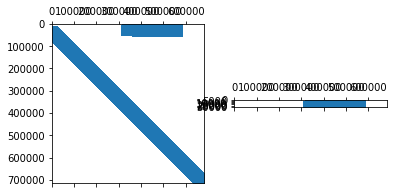

In [118]:
fig,axes = plt.subplots(1,2)
axes[0].spy(v2s_full_mat)
axes[1].spy(v2s_reduced_mat)
plt.show()

In [7]:
v2s_full = v2s_full_mat.dot(vtruth)
v2s_reduced = v2s_reduced_mat.dot(vtruth)
v2s2v_full = s2v_full_mat.dot(v2s_full)
v2s2v_reduced = s2v_reduced_mat.dot(v2s_reduced)
v2s2v_full_sp = linalg.lsqr(v2s_full_mat, v2s_full)[0]
v2s2v_reduced_sp = linalg.lsqr(v2s_reduced_mat, v2s_reduced)[0]

In [8]:
v2s_edge_full = v2s_edge_full_mat.dot(vtruth)
v2s_edge_reduced = v2s_edge_reduced_mat.dot(vtruth)
v2s2v_edge_reduced = s2v_reduced_mat.dot(v2s_edge_reduced)
v2s2v_edge_full = s2v_full_mat.dot(v2s_edge_full)
v2s2v_edge_reduced_sp = linalg.lsqr(v2s_edge_reduced_mat, v2s_edge_reduced)[0]
v2s2v_edge_full_sp = linalg.lsqr(v2s_edge_full_mat, v2s_edge_full)[0]

full 7.658911317367112
reduced 8.339105619178827
full_sp 2.1022084536219556e-06
reduced_sp 0.9248255253240769
edge_full 5.443918935626892
edge_reduced 4.478861083487031
edge_full_sp 5.567432812784336e-05
edge_reduced_sp 8.333072967674742


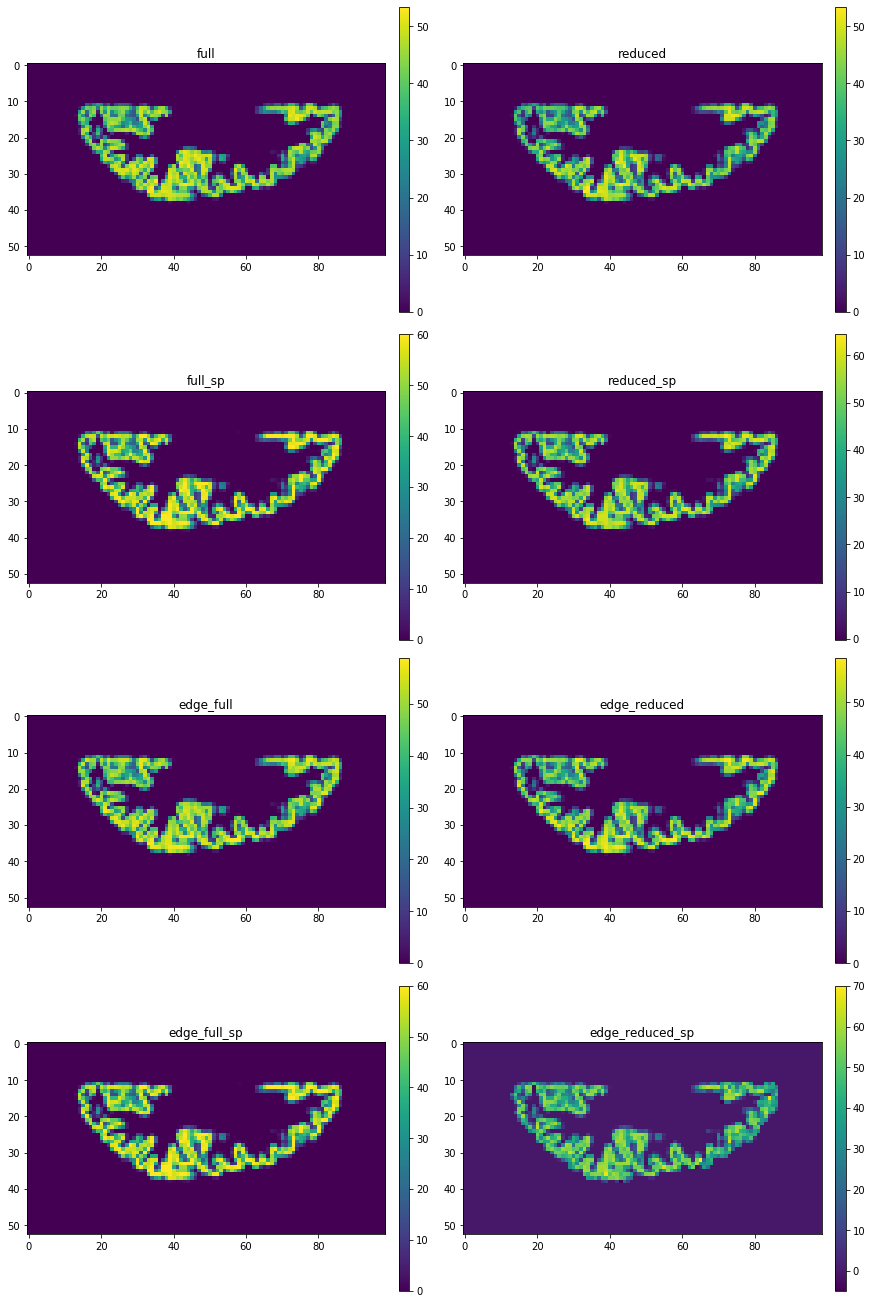

In [10]:
fig, axes = plt.subplots(4,2, constrained_layout=True)
fig.set_size_inches(12,18)
for ax,img,txt in zip(axes.flat, 
                      [v2s2v_full, v2s2v_reduced, v2s2v_full_sp, 
                       v2s2v_reduced_sp, v2s2v_edge_full, v2s2v_edge_reduced, 
                       v2s2v_edge_full_sp, v2s2v_edge_reduced_sp], 
                      ['full', 'reduced', 'full_sp', 'reduced_sp', 
                       'edge_full', 'edge_reduced', 'edge_full_sp', 'edge_reduced_sp']):
    print(txt, MASKED_RMS(vtruth, img, mask))
    obj = ax.imshow(img.reshape(spc.size)[30:,:,40])
    fig.colorbar(obj, ax=ax)
    ax.set_title(txt)

In [110]:
struth_reduced = 60 * np.ones(crop)
struth_full = np.concatenate((struth_reduced, np.zeros(vtruth.size)))

In [114]:
s2v_full = s2v_full_mat.dot(struth_full)
s2v_reduced = s2v_reduced_mat.dot(struth_reduced)
s2v2s_full = v2s_full_mat.dot(s2v_full)
s2v2s_reduced = v2s_reduced_mat.dot(s2v_reduced)
s2v2s_full_sp = linalg.lsqr(s2v_full_mat, s2v_full)[0]
s2v2s_reduced_sp = linalg.lsqr(s2v_reduced_mat, s2v_reduced)[0]
s2v2s_edge_full = v2s_edge_full_mat.dot(s2v_full)
s2v2s_edge_reduced = v2s_edge_reduced_mat.dot(s2v_reduced)

# s2v_edge_full = s2v_full_mat.dot(struth_full)
# s2v_edge_reduced = s2v_reduced_mat.dot(struth_reduced)
# s2v2s_edge_full_sp = linalg.lsqr(s2v_edge_full_mat, s2v_edge_full)[0]
# s2v2s_edge_reduced_sp = linalg.lsqr(s2v_edge_reduced_mat, s2v_edge_reduced)[0]

In [115]:
SHAPE = (2,3)
plotter = pyvista.BackgroundPlotter(shape=SHAPE)
mesh = to_polydata(plots)

for (X,Y),title,data in zip(itertools.product(*[range(s) for s in SHAPE]),
                    ['s2v2s_full', 's2v2s_reduced', 's2v2s_full_sp', 's2v2s_reduced_sp',
                     's2v2s_edge_full', 's2v2s_edge_reduced'], 
                     [s2v2s_full, s2v2s_reduced, s2v2s_full_sp, s2v2s_reduced_sp, 
                      s2v2s_edge_full, s2v2s_edge_reduced]):
    plotter.subplot(X,Y)
    x = plotter.add_mesh(mesh, scalars=data[:crop])
    err = np.sqrt(((struth - data[:crop])[depth_mask]**2).mean())
    plotter.add_text('%s, %2.1f' % (title, err))
    pos = plotter.camera_position
    
plotter.show()